### Step 0: Get packages and helper functions

In [1]:
# Add source and data file paths
import os
path = os.path.abspath(os.getcwd())
os.chdir("..")
parent_path = os.path.abspath(os.getcwd())

import sys 
sys.path.insert(1, parent_path + '\\source')
sys.path.insert(2, parent_path + '\\data')

import numpy as np; import torch; import time

# Import source/helper functions
from misc_helper import combine_layers, get_dt, get_userPar, training_loop, make_gif, load_log
from plot_helper import reference_plot, sample_plot
from trainingData_helper import generate_trainData
from windowSweep_helper import window_sweep_class
from pde_helper import PDE_class
from neuralNetwork_helper import Net, activation_func_a, weight_class, dtPINN

## Step 1: Define PDE problem and visualize 

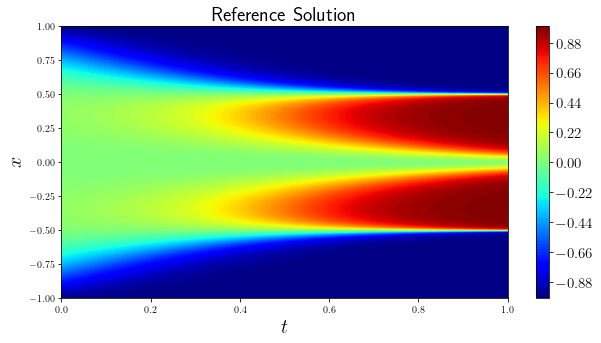

In [2]:
### Use data and automatically define PINN PDE residuals from pre-defined problem (i.e. 'convection', 'allen-cahn', or 'kdv' in paper)
pde_type = 'allen-cahn'
newParams = {}

### Choose to solve new problem. First generate data using a modified MATLAB chebfun solver in the DATA folder and then define the PDE problem here. 
#pde_type = 'new'
#newParams = {}; newParams['data'] = parent_path+'\\data\\convection.mat'; newParams['pde'] = 'u_t + 30*u_x'; newParams['IC'] = 'np.sin(x)';

PDE = PDE_class(pde_type, newParams)
dataPar = PDE.data()

# Reference solution
reference_plot(dataPar)

## Step 2: dtPINN user settings

In [3]:
### Neural network parameters
input_encoding = 1 # Boolean for encode input to enforce exact boundary condtions
M = 10; L = get_dt(dataPar['xmin'], dataPar['xmax'], 1) # Hyperparameters for exact BC encoding, not used if turned off
hidden_layers = [50, 50, 50, 50]; layers = combine_layers(input_encoding, M, hidden_layers) # PINN layers
# Note Adam and L-BFGS epoch/iterations are per frame for generating animations, the total amount is multiplied by the training loops defined below
# Will be cutoff early if a new network is added since optimizer needs to be reset via this control loop
adam_params = [500, 0.001] # Optimization Hyperparameters for Adam [epochs, learning rate]
lbfgs_params = [0.1, 500, None, -1, -1, 50] # Optimization Hyperparameters for LBFGS [learning rate, max iterations, max evaluations, tolerance gradient, tolerance change, history size]
adaptive_activation = 0 # Adaptive activation functions in NN
dirichlet_bc = 0 # Use Dirichlet boundary condtions based on reference solution (0 = no, 1 = yes), number of points will depend on reference solution not user-defined N_b
learned_weights = 0 # Deprecated
lambda_w = 100 # Weight applied to non PDE-reisudal loss terms

### Training data parameters
N_x = 100; N_t = 100; N_f = N_x*N_t # Number of collocation points in the ENTIRE domian (pre subdomain partitioning)
N_0 = 200 # Number of initial condtion points in the ENTIRE domain
N_b = 200 # Number of boundary condtion points in the ENTIRE domain
N_i = N_0 # Number of interface continuity points for each interface (total = N_i*(n-1))
collocation_sampling = 'lhs' # Latin-hypercube or grid sampling

### From Algorithm 1 in paper
## 1. Choose stacked-decomposition parameters [n, dS, adaptive dt]
num_partitions = 1; dt = get_dt(dataPar['tmin'], dataPar['tmax'], num_partitions) # Number of time-slabs in domain (1 = PINN) and dt derived from number and t-domain; 
dS = 1 # Number of continuously training segments
causal_dS = 1 # Boolean for adding in intial dS segments causality or not (0 = no, 1 = yes)
stacked_tol = 1*10**(-8)

## 2. Choose interface conditions [residual continuity, Cp continuity, other]
interface_condition = ['u'] # List of interface condtions to add (u = solution continuity, uavg = average solution continuity, residual = minimize residuals, rc = minimize residual continuity)
# [xPINN = 'uavg' + 'rc', C^p continuity = 'u' for first-order systems]

## 3. Choose transfer learning parameters [number of layers, trainability of layers]
# If all layers that are transfered and kept learnable = 'fine-tuning'
# If some layers that are transfered and made unlearnable = 'transfer learning'
layer_transfer = [1, 1, 1, 1, 1] # Boolean mask to transfer weights and bias (length = len(layers) - 1)
layer_trainability = [1, 1, 1, 1, 1] # Boolean mask to make layers continue to be learnable or not (length = len(layers) - 1)

## 4. Choose window-sweeping parameters [weighting scheme, scheme hyperparameters]
window_scheme = 'uniform'
scheme_parameters = [1*10**(-1), 1*10**(-7), 1*10**(-1), 1, 1, 1, 0]
# If 'none': , If 'uniform' or 'linear': width, propogate loss tolerance, dt, scale, use bc-set, use null-set, do adam iterations after propgating (L-BFGS nan's for large steps); 
# If 'erf': sharpness, propogate loss tolerance, dt, scale, set cutoff tolerance, use bc-set, use null-set; 
# If 'causual_weights': epsilon), bound tolerance

userPar = get_userPar(path, pde_type, input_encoding, M, L, layers, adam_params, lbfgs_params, adaptive_activation, learned_weights, N_x, N_t, N_f, N_0, N_b, N_i, collocation_sampling,\
                     num_partitions, dt, dS, causal_dS, interface_condition, layer_transfer, layer_trainability, window_scheme, scheme_parameters, PDE, stacked_tol, lambda_w, dirichlet_bc)

### Step 2.1: Generate and visualize training data

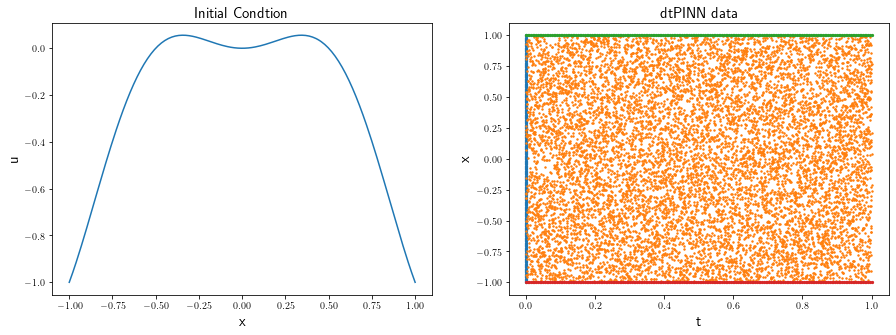

In [4]:
dataPar = generate_trainData(dataPar, userPar)
sample_plot(dataPar, userPar)

## Step 3: Train model and visualize

### Step 3.1: Define training and visualization parameters

In [5]:
### Training visualization parameters
userPar['animation'] = 0; # Boolean for showing/saving snapshots to make animation. If 0, it will just show/save the end of training
# Animation setting not working when using window_sweeping methods
userPar['save_fig'] = 1; # Save training figures
userPar['model_name'] = 'allen-cahn_example' # Name of file to save training snapshots under
userPar['show_fig'] = 0; # Display training figures
userPar['verbose'] = 1 # Print out various training varibles at train time such as loss and iterations
userPar['log'] = 1
SEED = 0

### Step 3.2: Initalize the model

In [6]:
print('SEED:', SEED); torch.manual_seed(SEED); np.random.seed(SEED);
model = dtPINN(dataPar, userPar)

SEED: 0


### Step 3.3: Train the model

In [7]:
adam_loops = 1 # Iterations per loop defined in prior adam_params
lbfgs_loops = 100 # Iterations per loop defined in prior lbfgs_params
model = training_loop(userPar, dataPar, model, adam_loops, lbfgs_loops)

dtPINN
Train Adam:
epoch 100, loss: 0.553764, delta loss: 0.0028156
epoch 200, loss: 0.377973, delta loss: 0.00104544
epoch 300, loss: 0.249209, delta loss: 0.00169285
epoch 400, loss: 0.0656816, delta loss: 0.00125136
epoch 500, loss: 0.021605, delta loss: 0.000123503
Training time: 14.8597
Train L-BFGS:
epoch 100, loss: 0.00638966, delta loss: 4.01763e-05
epoch 200, loss: 0.00356214, delta loss: 1.66164e-05
epoch 300, loss: 0.00206181, delta loss: 1.42029e-05
epoch 400, loss: 0.00137665, delta loss: 2.22353e-06
epoch 500, loss: 0.000989122, delta loss: 6.255e-06
Training time: 30.5654
Train L-BFGS:
epoch 100, loss: 0.000712249, delta loss: 1.45636e-06
epoch 200, loss: 0.000563795, delta loss: 1.55304e-06
epoch 300, loss: 0.000391499, delta loss: 1.07175e-06
epoch 400, loss: 0.000297199, delta loss: 5.49655e-07
epoch 500, loss: 0.000256841, delta loss: 3.55882e-07
Training time: 46.0484
Train L-BFGS:
epoch 100, loss: 0.000226693, delta loss: 1.86134e-07
epoch 200, loss: 0.000190591, d

### Step 3.4: Make animation if figures were saved or load run log

In [8]:
if userPar['animation'] == 1:
    make_gif(userPar)
    
if userPar['log'] == 1:
    log = load_log(userPar)